In [1]:
#%% Configuration Cell
import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import splitfolders
from timm.data.auto_augment import rand_augment_transform
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
from timm.models import deit_base_patch16_224
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

# Configuration
NUM_CLASSES = 6
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
LR = 3e-5
WARMUP_EPOCHS = 5
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brain Tumour\\Brain Tumour Dataset - Radiology Team - 6 Classes"
SPLIT_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brain Tumour\\Dataset"
NUM_WORKERS = 4
SEED = 42

# Set seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
#%% Data Preparation Cell
def prepare_dataset():
    # Split dataset into train/val/test (70/15/15)
    splitfolders.ratio(
        DATA_ROOT,
        output=SPLIT_ROOT,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

prepare_dataset()

# DeiT-specific transforms
def get_transforms():
    # RandAugment parameters from original DeiT paper
    ra_params = {
        "translate_const": 100,
        "img_mean": tuple([min(255, round(255 * x)) for x in [0.485, 0.456, 0.406]]),
    }
    
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
        transforms.RandomHorizontalFlip(),
        rand_augment_transform("rand-m9-mstd0.5", ra_params),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3))
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(IMG_SIZE + 32),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

train_transform, val_transform = get_transforms()

# Create datasets
train_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'val'), val_transform)
test_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'test'), val_transform)

# Get class weights for imbalance handling
class_counts = np.bincount(train_dataset.targets)
class_weights = torch.tensor(1. / (class_counts / class_counts.max()), dtype=torch.float32)

Copying files: 7622 files [00:09, 785.80 files/s]


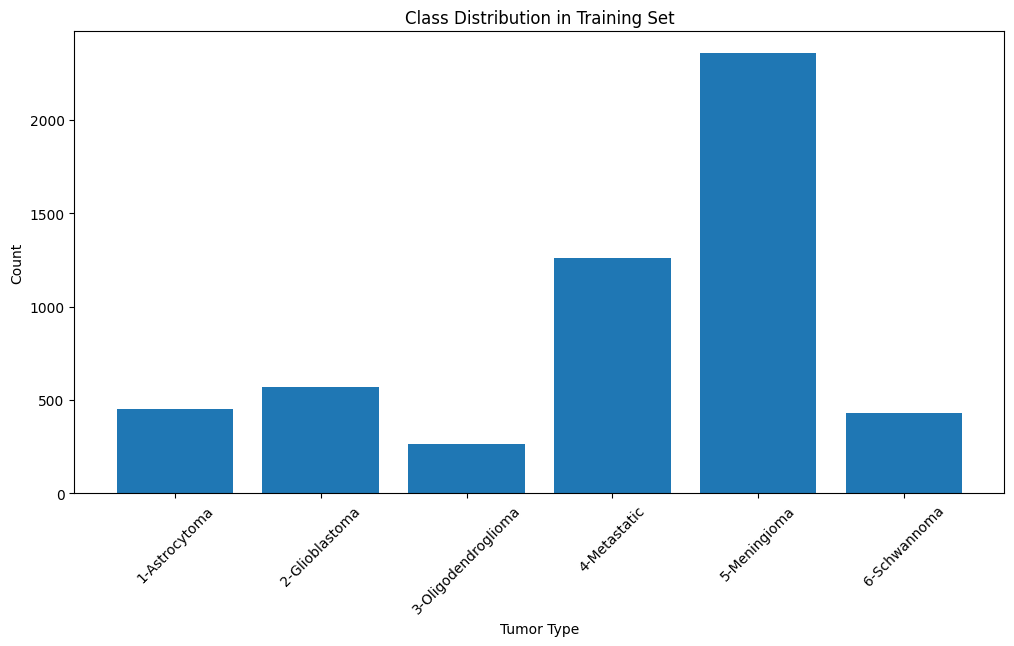

In [3]:
#%% Data Visualization Cell
def plot_class_distribution():
    counts = np.bincount(train_dataset.targets)
    class_names = train_dataset.classes
    
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Tumor Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution()

In [4]:
#%% Model Definition Cell (Fixed)
class BrainTumorDeiT(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        self.deit = deit_base_patch16_224(pretrained=pretrained)
        self.deit.head = nn.Sequential(
            nn.Linear(self.deit.head.in_features, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # Freeze/unfreeze layers
        for param in self.deit.parameters():
            param.requires_grad = False
        for block in self.deit.blocks[-4:]:
            for param in block.parameters():
                param.requires_grad = True
        for param in self.deit.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.deit(x)

class LitBrainTumor(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        self.model = BrainTumorDeiT()
        
        # Custom loss function for mixup
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        # Metrics
        self.train_acc = MulticlassAccuracy(num_classes=NUM_CLASSES)
        self.val_acc = MulticlassAccuracy(num_classes=NUM_CLASSES)
        self.test_acc = MulticlassAccuracy(num_classes=NUM_CLASSES)
        self.f1 = MulticlassF1Score(num_classes=NUM_CLASSES)
        
        # Mixup/Cutmix
        self.mixup_fn = Mixup(
            mixup_alpha=0.8,
            cutmix_alpha=1.0,
            prob=1.0,
            switch_prob=0.5,
            mode='batch',
            num_classes=NUM_CLASSES  # Add this line
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = self.mixup_fn(x, y)
        logits = self(x)
        
        # Use standard CrossEntropyLoss for mixup targets
        loss = self.criterion(logits, y.argmax(1))  # Changed to use argmax for mixup targets
        
        self.train_acc(logits.softmax(1), y.argmax(1))
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weights)(logits, y)
        
        self.val_acc(logits.softmax(1), y)
        self.f1(logits.softmax(1), y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        self.log('val_f1', self.f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weights)(logits, y)
        
        self.test_acc(logits.softmax(1), y)
        self.f1(logits.softmax(1), y)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        self.log('test_f1', self.f1)

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=LR,
            weight_decay=0.05,
            betas=(0.9, 0.999)
        )
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=EPOCHS - WARMUP_EPOCHS,
            eta_min=1e-6
        )
        
        warmup = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda epoch: min(1., (epoch + 1) / WARMUP_EPOCHS)
        )
        
        return [optimizer], [
            {'scheduler': warmup, 'interval': 'epoch', 'frequency': 1},
            {'scheduler': scheduler, 'interval': 'epoch', 'frequency': 1}
        ]

In [5]:
#%% Training Execution Cell (Fixed)
# Initialize model with class weights
model = LitBrainTumor(class_weights=class_weights)

# Callbacks
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_f1',  # Monitor F1 score for checkpointing
    mode='max',        # Maximize F1 score
    save_top_k=3,      # Save top 3 models
    filename='best-{epoch}-{val_f1:.2f}'  # Filename format
)

early_stop = pl.callbacks.EarlyStopping(
    monitor='val_f1',  # Monitor F1 score
    patience=15,       # Stop after 15 epochs without improvement
    mode='max',        # Maximize F1 score
    min_delta=0.001    # Minimum improvement required
)

lr_monitor = pl.callbacks.LearningRateMonitor()  # Monitor learning rate

# Trainer configuration
trainer = pl.Trainer(
    accelerator='auto',  # Automatically select GPU if available
    devices=1,           # Use 1 device
    max_epochs=EPOCHS,   # Maximum number of epochs
    callbacks=[checkpoint, early_stop, lr_monitor],  # Attach callbacks
    precision='16-mixed',  # Use mixed precision for faster training
    deterministic=True,    # Ensure reproducibility
    enable_progress_bar=True,  # Show progress bar
    log_every_n_steps=10       # Log metrics every 10 steps
)

# Data loaders with persistent workers for faster training
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    pin_memory=True  # Pin memory for faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    pin_memory=True
)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Load the best model checkpoint
best_model = LitBrainTumor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,  # Path to the best checkpoint
    class_weights=class_weights  # Pass class weights to the loaded model
)

# Test the best model
trainer.test(best_model, test_loader)

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\accelerator_connector.py:557: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\DELL 5540\Desktop\Brain Tumour\lightning_logs

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | BrainTumorDeiT     | 86.2 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
5 | f1        | MulticlassF1Score  | 0     
-------------------------------------------------
28.7 M    Trainable params
57.4 M    Non-

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'LitBrainTumor' object has no attribute 'class_weights'

In [19]:
#%% Training Execution Cell
trainer.fit(model, train_loader, val_loader)
best_model = LitBrainTumor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    class_weights=class_weights
)

Missing logger folder: c:\Users\DELL 5540\Desktop\Brain Tumour\lightning_logs

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | BrainTumorDeiT         | 86.2 M
1 | criterion | SoftTargetCrossEntropy | 0     
2 | train_acc | MulticlassAccuracy     | 0     
3 | val_acc   | MulticlassAccuracy     | 0     
4 | test_acc  | MulticlassAccuracy     | 0     
5 | f1        | MulticlassF1Score      | 0     
-----------------------------------------------------
28.7 M    Trainable params
57.4 M    Non-trainable params
86.2 M    Total params
344.782   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: The size of tensor a (1000) must match the size of tensor b (6) at non-singleton dimension 1

In [ ]:
#%% Evaluation Cell
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            logits = model(x)
            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=train_dataset.classes))

evaluate_model(best_model, test_loader)

In [ ]:
#%% Visualization Cell
def plot_training_curves(trainer):
    metrics = trainer.logged_metrics
    
    plt.figure(figsize=(15, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss_epoch'], label='Train')
    plt.plot(metrics['val_loss_epoch'], label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc_epoch'], label='Train')
    plt.plot(metrics['val_acc_epoch'], label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(trainer)

In [ ]:
#%% Inference Cell
def predict(image_path, model=best_model):
    # Preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize(IMG_SIZE + 32),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
    
    return {cls: f"{prob:.2%}" for cls, prob in zip(train_dataset.classes, probs[0].tolist())}

# Example usage
sample_image = "/path/to/test_image.jpg"
print(predict(sample_image))